# Financial Risk Metrics
---
This notebook measures the risk characteristics of the S&P 500 index throughout its entire history. The notebook starts by calculating static risk metrics. Then the notebook explores tail-end risk metrics to quantify large losses with small probabilities. To conclude the experiment, we calculate and observe temporal risk metrics.

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import yfinance as yf

# Import settings
plt.style.use('ggplot')

# Download historical S&P 500 data, calculate daily returns
data = yf.download('^GSPC', period='max', interval='1d', auto_adjust=True)['Close']
data['returns'] = data['^GSPC'].pct_change()
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


Average Return:      0.00030959497714619583
Standard Deviation:  0.011954477335647327
Skew of Returns:     -0.10902832369081612
Kurtosis of Returns: 17.226106473297577


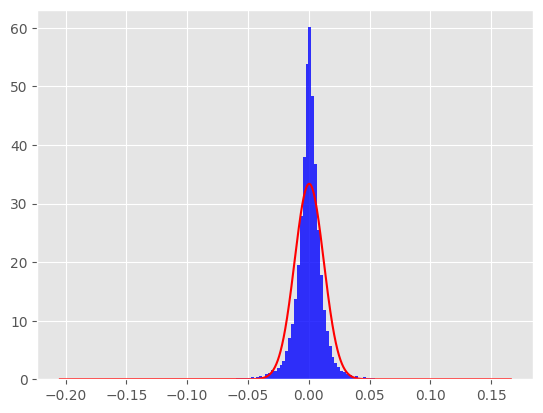

In [32]:
# Plot the frequency distribution of returns.
# Overlay a normal distribution with same mean (u) and
# standard deviation (sd) as the historical return set.

u = np.mean(data['returns'])
sd = np.std(data['returns'])
skew = data['returns'].skew()
kurt = data['returns'].kurt()

print(f'Average Return:      {u}')
print(f'Standard Deviation:  {sd}')
print(f'Skew of Returns:     {skew}')
print(f'Kurtosis of Returns: {kurt}')

# Calulate the normal distribution
x = np.linspace(min(data['returns']), max(data['returns']), len(data['returns']))
y = stats.norm.pdf(x, u, sd)

fig, ax = plt.subplots()

# Plot the return frequency
nBins = int(np.sqrt(len(data['returns'])))
ax.hist(data['returns'], bins=nBins, alpha=0.8, color='blue', label='Return Distribution', density=True)

# Plot the normal distribution
ax.plot(x, y, color='red', label='Normal')
plt.show()

We can observe that the returns for the S&P 500 are only approximately normally distributed. A greater frequency of returns is present closer to the mean, more than the normal distribution suggests. The distribution of returns is almost fully symmetrical, shown by the small skew. Where the divergence from the normal disctribution occurs most is in the tail behavior. The kurtosis is quite high, indicating that there is more probability mass in the tails of the distribution. Becasue the return distribution is only approximately normal, standard deviation is an incomplete measure of risk. More specifically, additional measures are needed to quantify tail risk.

In [33]:
minReturn = min(data['returns'])
maxReturn = max(data['returns'])

print(f'Maximum Return: {maxReturn}')
print(f'Minimum Return: {minReturn}')

Maximum Return: 0.16609585014510864
Minimum Return: -0.20466930799694372


#### 1. Value at Risk (VaR)
Value at Risk is a method of assessing financial risk using standard statistical techniques summarizing the worst-loss over a target horizon that will not be exceeded with a given confidence interval. The 99% VaR may be viewed as the cutoff seperating the 1% worst-case future scenarios from the rest of the distribution.

99% Value at Risk:   -0.034395960133213554
99.9% Value at Risk: -0.07596969747745097


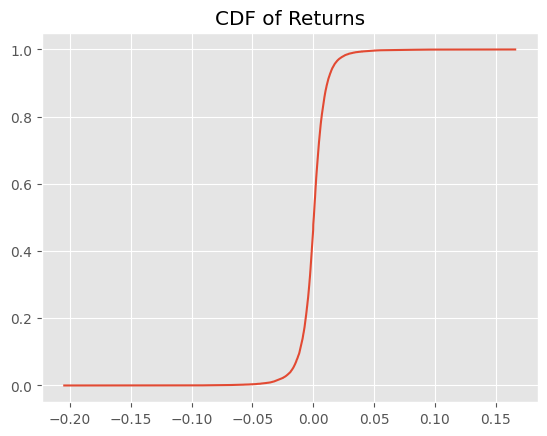

In [34]:
sorted_returns = np.sort(data['returns'])
pct99 = int(0.01 * len(sorted_returns))
pct99_9 = int(0.001 * len(sorted_returns))

# Calculate the sample estimates of VaR (99% and 99.9%)
VaR99 = sorted_returns[pct99]
VaR99_9 = sorted_returns[pct99_9]

print(f'99% Value at Risk:   {VaR99}')
print(f'99.9% Value at Risk: {VaR99_9}')

# Plot the cummulative distribution of returns
cumm_probabilities = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)

plt.plot(sorted_returns, cumm_probabilities)
plt.title('CDF of Returns')
plt.show()

#### 2. Expected Shortfall
Expected shortfall provides greater insights into the magnitude of returns within the left-tail of the distribution by averaging the returns below a percentile. Value at Risk gives the return at a certain percentile, whereas expected shortfall provides information as to the behavior of the left-tail.

In [35]:
# Average the worst returns in the tail
worst_99pct = sorted_returns[0:pct99+1]
worst_99_9pct = sorted_returns[0:pct99_9+1]

# Calculate the expected shortfall estimate (1% and 0.1%)
excepted_shortfall99 = np.mean(worst_99pct)
expected_shortfall99_9 = np.mean(worst_99_9pct)

print(f'1% Expected Shortfall:   {excepted_shortfall99}')
print(f'0.1% Expected Shortfall: {expected_shortfall99_9}')

1% Expected Shortfall:   -0.05085343727824713
0.1% Expected Shortfall: -0.09471649676768198


#### 3. Lower Partial Standard Deviation

#### 4. Relative Frequency of 3-Sigma Returns

## Temporal Statistics
Rolling Standard Deviation
Term Structure of Mean
Term Structure of Volatility
Term Structure of Up/Down Volatility
Term Structure of Skew
Term Structure of Kurtosis